In [1]:
from utils import *
from models import *
from loss import *
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime

In [2]:
train_path = '../next_day_fires/next_day_wildfire_spread_train*'
val_path = '../next_day_fires/next_day_wildfire_spread_eval*'
test_path = '../next_day_fires/next_day_wildfire_spread_test*'
features = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']

# Load Data

## Training Data

In [3]:
train_dataset = get_dataset(
      train_path,
      data_size=64,
      sample_size=64,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

train_inputs, train_labels = next(iter(train_dataset))

print(train_inputs.shape)
print(train_labels.shape)

torch.Size([100, 12, 64, 64])
torch.Size([100, 1, 64, 64])


In [4]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

n_rows = 5
n_features = train_inputs.shape[3] 
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

In [5]:
# fig = plt.figure(figsize=(20,8))

# for i in range(n_rows):
#   for j in range(n_features + 1):
#     plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
#     if i == 0:
#       plt.title(titles[j], fontsize=15)
#     if j < n_features - 1:
#       plt.imshow(train_inputs[i, j, :, :], cmap='viridis')
#     if j == n_features - 1:
#       plt.imshow(train_inputs[i, -1, :, :], cmap=CMAP, norm=NORM)
#     if j == n_features:
#       plt.imshow(train_labels[i, 0, :, :], cmap=CMAP, norm=NORM) 
#     plt.axis('off')
# plt.tight_layout()

## Vlidation Data

In [6]:
val_dataset = get_dataset(
      val_path,
      data_size=64,
      sample_size=64,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

val_inputs, val_labels = next(iter(val_dataset))

print(val_inputs.shape)
print(val_labels.shape)

torch.Size([100, 12, 64, 64])
torch.Size([100, 1, 64, 64])


## Test Data

In [7]:
test_dataset = get_dataset(
      test_path,
      data_size=64,
      sample_size=64,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test_inputs, test_labels = next(iter(val_dataset))

print(test_inputs.shape)
print(test_labels.shape)

torch.Size([100, 12, 64, 64])
torch.Size([100, 1, 64, 64])


In [8]:
# Build DataLoader
train_loader = DataLoader(train_dataset, batch_size=None, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=None, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=None, num_workers=0, pin_memory=True)

# Model Initialization

In [9]:
folder_path = './gen_models'
gen_input_channels = 12
disc_input_channels = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Loss function setup
# Create a class for Dice Loss
class DiceLoss(nn.Module):
    # Initializing the loss function will require a smoothing parameter to prevent division by zero 
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    # The loss function is defined in a forward pass as 2*(intersection)/(pred + true)
    def forward(self, pred, true):
        pred = pred.view(-1)
        true = true.view(-1)
        intersection = (pred*true).sum()
        dice = (2*intersection + self.smooth) / (pred.sum() + true.sum() + self.smooth)
        return 1 - dice

# Create a class for BCE Loss
class BCEDiceLoss(nn.Module):
    # Initializing the loss function will require a BCE weight parameter to determine the weigth of each loss 
    def __init__(self, bce_weight=0.5):
        super().__init__()
        # Declare both loss functions
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    # The loss function is defined by taking the weighted sum of BCE Loss and Dice Loss
    def forward(self, pred, true):
        bce_loss = self.bce(pred, true)
        dice_loss = self.dice(pred, true)
        return self.bce_weight * bce_loss + (1-self.bce_weight) * dice_loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# --- Model 정의 (이전과 동일) ---
class MultiKernelCNN(nn.Module):
    def __init__(self, in_channels=12):
        super().__init__()
        # Encoder: B1~B5
        self.b1_conv3 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.b1_conv5 = nn.Conv2d(in_channels, 16, kernel_size=5, padding=2)
        self.b1_conv7 = nn.Conv2d(in_channels, 16, kernel_size=7, padding=3)
        self.b1_pool  = nn.MaxPool2d(2)

        self.b2_conv3 = nn.Conv2d(16*3, 32, kernel_size=3, padding=1)
        self.b2_conv5 = nn.Conv2d(16*3, 32, kernel_size=5, padding=2)
        self.b2_conv7 = nn.Conv2d(16*3, 32, kernel_size=7, padding=3)
        self.b2_pool  = nn.MaxPool2d(2)

        self.b3_conv3 = nn.Conv2d(32*3, 64, kernel_size=3, padding=1)
        self.b3_conv5 = nn.Conv2d(32*3, 64, kernel_size=5, padding=2)
        self.b3_conv7 = nn.Conv2d(32*3, 64, kernel_size=7, padding=3)
        self.b3_pool  = nn.MaxPool2d(2)

        self.b4_conv3 = nn.Conv2d(64*3, 128, kernel_size=3, padding=1)
        self.b4_conv5 = nn.Conv2d(64*3, 128, kernel_size=5, padding=2)
        self.b4_conv7 = nn.Conv2d(64*3, 128, kernel_size=7, padding=3)
        self.b4_pool  = nn.MaxPool2d(2)

        self.b5_conv3 = nn.Conv2d(128*3, 256, kernel_size=3, padding=1)
        self.b5_conv5 = nn.Conv2d(128*3, 256, kernel_size=5, padding=2)
        self.b5_conv7 = nn.Conv2d(128*3, 256, kernel_size=7, padding=3)
        self.b5_pool  = nn.MaxPool2d(2)

        # Decoder: B6(flatten) + B7
        # B5 출력: (batch, 768, 2, 2)
        self.flat_dim = 256*3*2*2  # = 3072
        self.fc1 = nn.Linear(self.flat_dim, 128)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 256)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 4096)

    def forward(self, x):
        # B1
        c3 = F.relu(self.b1_conv3(x))
        c5 = F.relu(self.b1_conv5(x))
        c7 = F.relu(self.b1_conv7(x))
        x  = self.b1_pool(torch.cat([c3, c5, c7], dim=1))
        # B2
        c3 = F.relu(self.b2_conv3(x))
        c5 = F.relu(self.b2_conv5(x))
        c7 = F.relu(self.b2_conv7(x))
        x  = self.b2_pool(torch.cat([c3, c5, c7], dim=1))
        # B3
        c3 = F.relu(self.b3_conv3(x))
        c5 = F.relu(self.b3_conv5(x))
        c7 = F.relu(self.b3_conv7(x))
        x  = self.b3_pool(torch.cat([c3, c5, c7], dim=1))
        # B4
        c3 = F.relu(self.b4_conv3(x))
        c5 = F.relu(self.b4_conv5(x))
        c7 = F.relu(self.b4_conv7(x))
        x  = self.b4_pool(torch.cat([c3, c5, c7], dim=1))
        # B5
        c3 = F.relu(self.b5_conv3(x))
        c5 = F.relu(self.b5_conv5(x))
        c7 = F.relu(self.b5_conv7(x))
        x  = self.b5_pool(torch.cat([c3, c5, c7], dim=1))

        # Flatten (B6)
        x = x.reshape(x.size(0), -1)

        # Decoder (B7)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))

        # Reshape to (batch, 1, 64, 64)
        x = x.contiguous().view(-1, 1, 64, 64)
        x = F.sigmoid(x)

        return x


# --- 학습/검증 함수 ---
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)


if __name__ == '__main__':
    # 하이퍼파라미터
    batch_size = 16
    lr = 1e-3
    epochs = 500
    patience = 100  # EarlyStopping patience
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = "cpu"

    # 모델/옵티마이저/손실함수
    model = MultiKernelCNN(in_channels=12).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #criterion = nn.BCEWithLogitsLoss()
    criterion = BCEDiceLoss()

    # EarlyStopping 준비
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None

    for epoch in range(1, epochs+1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss   = eval_epoch(model, val_loader, criterion, device)
        print(f'Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

        # 검증 손실 개선 시 best model 갱신
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = model.state_dict()  # state 저장
            print(f'  → New best model at epoch {epoch} (Val Loss: {val_loss:.4f})')
        # patience 초과 시 조기 종료
        elif epoch - best_epoch >= patience:
            print(f'No improvement for {patience} epochs. Early stopping.')
            break

    # 학습 완료 후 best model state 저장
    save_path = 'best_multikernel_cnn.pth'
    torch.save(best_state, save_path)
    print(f'Best model (epoch {best_epoch}) saved to "{save_path}"')


RuntimeError: all elements of input should be between 0 and 1

# Model Testing

In [ ]:
import numpy as np
import torch

# 1) 저장해 둔 best model state 불러오기
model = MultiKernelCNN(in_channels=12).to(device)
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# 2) 예측 및 GT 저장용 리스트
pred_mask_all, target_all = [], []

with torch.no_grad():
    for batch in test_loader:
        images, target = batch
        images = images.to(device)
        target = target.to(device)

        # 모델로 예측
        pred_mask = model(images)  # (B,1,64,64)

        # CPU numpy로 변환
        pred_mask_all.append(pred_mask.cpu().numpy())
        target_all.append(target.cpu().numpy())

# 3) 배치 단위로 쌓기
preds = np.concatenate(pred_mask_all, axis=0)   # (N,1,64,64)
trues = np.concatenate(target_all,    axis=0)   # (N,1,64,64)

# 4) 채널 차원 제거 → (N,64,64)
if preds.ndim == 4 and preds.shape[1] == 1:
    preds = preds.squeeze(1)
    trues = trues.squeeze(1)

# 5) 이진화
preds = (preds > 0.5).astype(np.uint8)
trues = trues.astype(np.uint8)

# 6) 1차원으로 평탄화
preds = preds.flatten()
trues = trues.flatten()

# 7) TP, FP, FN 계산
tp = np.logical_and(preds == 1, trues == 1).sum()
fp = np.logical_and(preds == 1, trues == 0).sum()
fn = np.logical_and(preds == 0, trues == 1).sum()

# 8) 평가 지표 계산
smooth = 1e-6
dice   = (2 * tp + smooth) / (2 * tp + fp + fn + smooth)
iou    = (tp + smooth)     / (tp + fp + fn + smooth)
recall = tp / (tp + fn + smooth)

metrics = {
    'Dice Coefficient': dice,
    'IoU':              iou,
    'Recall':           recall
}

# 9) 결과 출력
print("\n** Test Results **")
for name, val in metrics.items():
    print(f"{name}: {val:.4f}")



** Test Results **
Dice Coefficient: 0.0000
IoU: 0.0000
Recall: 0.0000


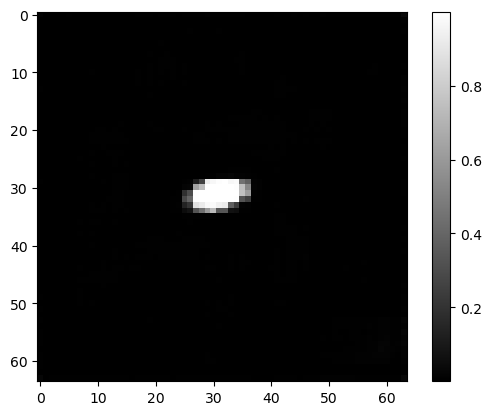

array([[1.5523713e-02, 2.1711674e-03, 3.1043240e-03, ..., 5.9760511e-03,
        4.7168601e-03, 3.4877859e-02],
       [2.9320326e-03, 9.3457777e-05, 1.3074014e-04, ..., 9.8227181e-05,
        8.4179344e-05, 6.1061801e-03],
       [1.8663486e-03, 9.4545794e-05, 2.1850606e-04, ..., 9.4343246e-05,
        1.1262294e-04, 2.8737576e-03],
       ...,
       [4.4909334e-03, 3.9280386e-04, 3.3029218e-04, ..., 9.3791768e-04,
        7.6642464e-04, 7.8037181e-03],
       [2.6725738e-03, 2.0635496e-04, 5.1399518e-04, ..., 5.8521749e-04,
        8.1473339e-04, 4.7748010e-03],
       [2.4534505e-02, 3.2045175e-03, 3.9635878e-03, ..., 4.1040569e-03,
        5.2216463e-03, 3.2320552e-02]], dtype=float32)

In [ ]:
img, lab = next(iter(test_loader))
pred = model(img.to(device))
tensor_np = pred[22][0].detach().cpu().numpy()
#tensor_np = pred[22][0]

#tensor_np = (tensor_np > 0.5).astype(int)
plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()
tensor_np

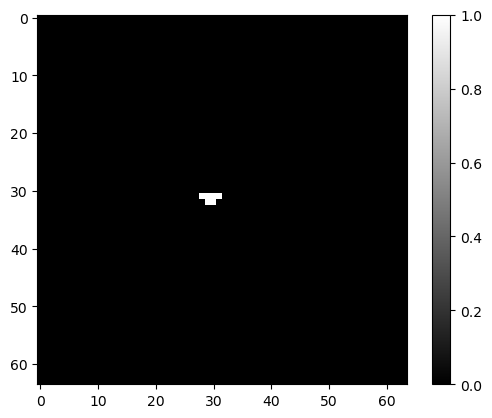

In [ ]:
tensor_np = lab[22][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()